ideas for different way to detrend and deseason data: https://www.machinelearningplus.com/time-series/time-series-analysis-python/

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from scipy import signal

In [3]:
tempelhof=pd.read_csv('TG_STAID002759.txt', skiprows=20, names=['SOUID', 'DATE', 'temp', 'Q_TG'], 
                 dtype={'SOUID':'int64', 'temp':'int64','Q_TG':'int64'})
tempelhof=tempelhof.set_index(pd.to_datetime(tempelhof.DATE, format='%Y%m%d', errors='ignore')).drop('DATE', axis=1)
tempelhof=tempelhof['2010':].drop('Q_TG', axis=1)
tempelhof['month_name']=tempelhof.index.month_name()
tempelhof['month']=tempelhof.index.month
tempelhof['year']=tempelhof.index.year

**Unit of temperature in raw data is 0.1 C, so must convert**

In [4]:
tempelhof['temp']=tempelhof['temp']/10

In [5]:
tempelhof.head()

,SOUID,temp,month_name,month,year
DATE,,,,,
2010-01-01,111448,-1.4,January,1,2010
2010-01-02,111448,-1.7,January,1,2010
2010-01-03,111448,-4.3,January,1,2010
2010-01-04,111448,-5.6,January,1,2010
2010-01-05,111448,-6.0,January,1,2010


## Brief EDA

Text(0.5, 1.0, 'Monthly temperature change at Berlin Tempelhof 2010-2020')

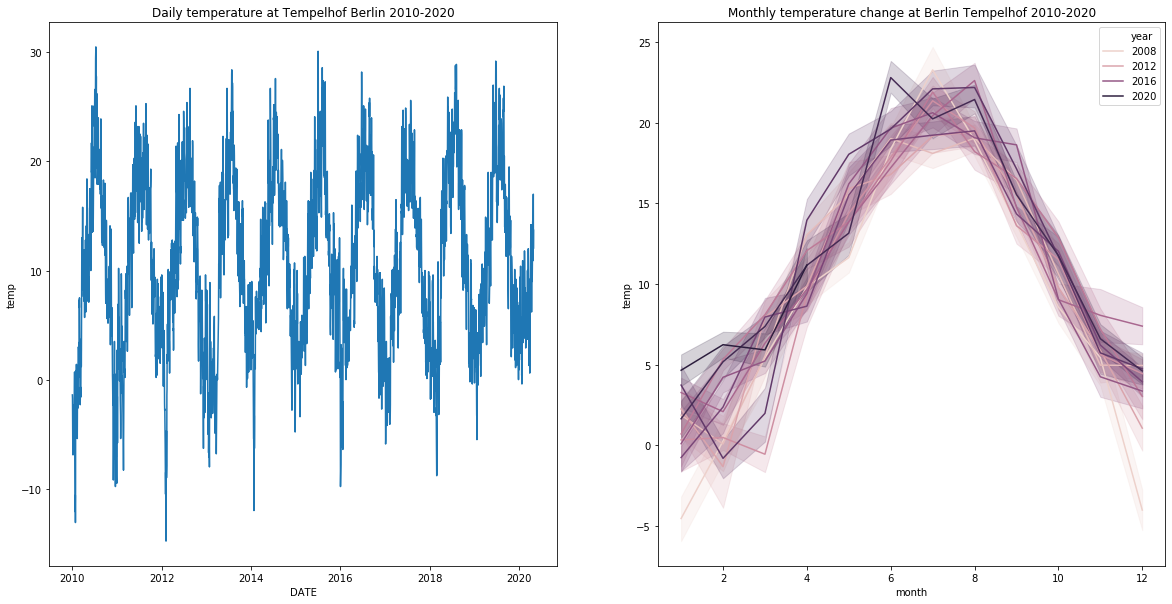

In [6]:
fig, ax=plt.subplots(1,2, figsize=(20,10))
sns.lineplot(x=tempelhof.index, y=tempelhof.temp, ax=ax[0]).set_title('Daily temperature at Tempelhof Berlin 2010-2020')
sns.lineplot(x='month', y='temp', hue='year', data=tempelhof, ax=ax[1]).set_title('Monthly temperature change at Berlin Tempelhof 2010-2020')

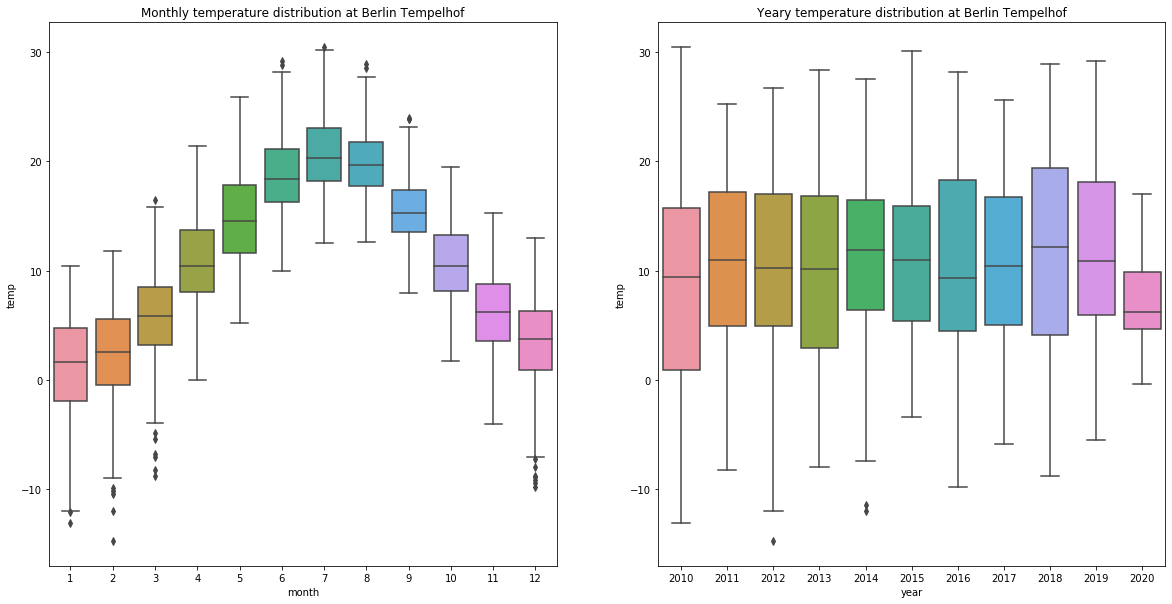

In [7]:
fig, ax=plt.subplots(1,2, figsize=(20,10))
sns.boxplot(x='month', y='temp', data=tempelhof, ax=ax[0]).set_title('Monthly temperature distribution at Berlin Tempelhof')
sns.boxplot(x='year', y='temp', data=tempelhof, ax=ax[1]).set_title('Yeary temperature distribution at Berlin Tempelhof')
plt.savefig('EDA.png')

### A brief look at complete decomposition of the data

/Users/gdquiceno2/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  


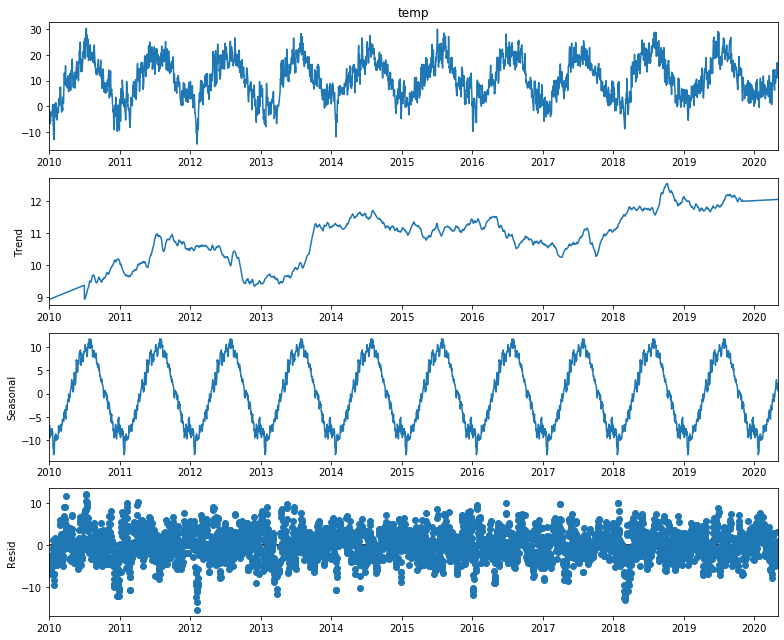

In [8]:
rcParams['figure.figsize'] = 11, 9
sdr=seasonal_decompose(tempelhof['temp'], model='additive', extrapolate_trend='freq', freq=365)
sdr.plot()
None

In [9]:
tempelhof_reconstruct=pd.concat([sdr.seasonal, sdr.trend, sdr.resid, sdr.observed], axis=1)
tempelhof_reconstruct.columns=['seasonal', 'trend', 'residual', 'actual_values']

In [10]:
tempelhof_reconstruct.head()

,seasonal,trend,residual,actual_values
DATE,,,,
2010-01-01,-7.711347,8.940204,-2.628857,-1.4
2010-01-02,-6.792543,8.942640,-3.850097,-1.7
2010-01-03,-7.927139,8.945076,-5.317937,-4.3
2010-01-04,-9.307239,8.947511,-5.240273,-5.6
2010-01-05,-9.470925,8.949947,-5.479022,-6.0


### Initial test for stationarity

In [11]:
adf_result=adfuller(tempelhof.temp.values, autolag='AIC')

In [12]:
print(f'ADF statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

ADF statistic: -4.382252729608631
p-value: 0.00031905124194152545


**according to the ADF test, null hypothesis is rejected and the data is already stationary**

In [14]:
kpss_result=kpss(tempelhof.temp.values, regression='c')

/Users/gdquiceno2/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [15]:
print(f'KPSS statistic: {kpss_result[0]}')
print(f'p-value: {kpss_result[1]}')

KPSS statistic: 0.11390197451687355
p-value: 0.1


**according to the KPSS test, null hypothesis is accepted and the data is already stationary**

### Detrend data

In [16]:
# method 1
tempelhof['diff1']=tempelhof['temp'].diff()

In [17]:
# method 2: subtract best fit line
tempelhof['diff2']=signal.detrend(tempelhof.temp.values)

In [18]:
# method 3: subtract trend component
tempelhof['diff3']=tempelhof.temp.values-sdr.trend

In [19]:
tempelhof.head()

,SOUID,temp,month_name,month,year,diff1,diff2,diff3
DATE,,,,,,,,
2010-01-01,111448,-1.4,January,1,2010,NaN,-11.091719,-10.340204
2010-01-02,111448,-1.7,January,1,2010,-0.3,-11.392233,-10.642640
2010-01-03,111448,-4.3,January,1,2010,-2.6,-13.992746,-13.245076
2010-01-04,111448,-5.6,January,1,2010,-1.3,-15.293260,-14.547511
2010-01-05,111448,-6.0,January,1,2010,-0.4,-15.693773,-14.949947


In [20]:
tempelhof.head()

,SOUID,temp,month_name,month,year,diff1,diff2,diff3
DATE,,,,,,,,
2010-01-01,111448,-1.4,January,1,2010,NaN,-11.091719,-10.340204
2010-01-02,111448,-1.7,January,1,2010,-0.3,-11.392233,-10.642640
2010-01-03,111448,-4.3,January,1,2010,-2.6,-13.992746,-13.245076
2010-01-04,111448,-5.6,January,1,2010,-1.3,-15.293260,-14.547511
2010-01-05,111448,-6.0,January,1,2010,-0.4,-15.693773,-14.949947


Text(0.5, 1.0, 'Comparing detrending methods')

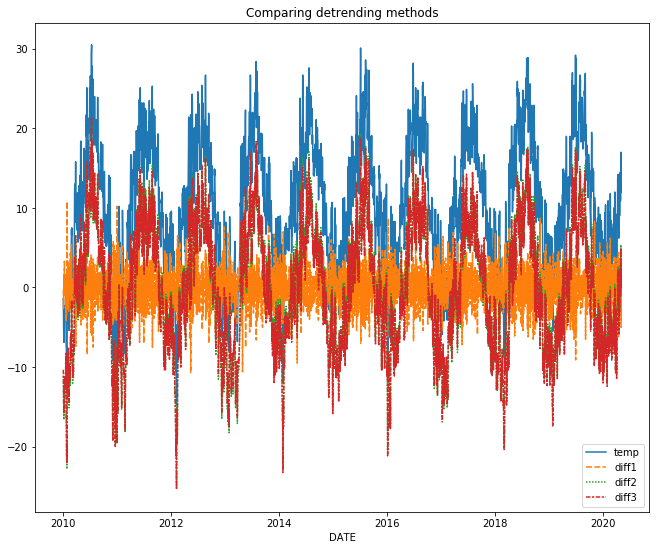

In [21]:
sns.lineplot(data=tempelhof.drop(['SOUID', 'month_name', 'month', 'year'], axis=1)).set_title('Comparing detrending methods')

**based on graph, method 1 detrended data the best, will continue with that one**

### Deseasonalize data 

In [22]:
# method 1
tempelhof['monthly_mean']=tempelhof.groupby('month')['diff1'].transform('mean')
tempelhof['deseason1']=tempelhof['diff1']-tempelhof['monthly_mean']

In [23]:
# method 2
tempelhof['deseason2']=tempelhof.temp.values/sdr.seasonal

In [24]:
tempelhof.fillna(method='bfill', inplace=True)

In [25]:
tempelhof.head()

,SOUID,temp,month_name,month,year,diff1,diff2,diff3,monthly_mean,deseason1,deseason2
DATE,,,,,,,,,,,
2010-01-01,111448,-1.4,January,1,2010,-0.3,-11.091719,-10.340204,-0.081471,-0.218529,0.181551
2010-01-02,111448,-1.7,January,1,2010,-0.3,-11.392233,-10.642640,-0.081471,-0.218529,0.250274
2010-01-03,111448,-4.3,January,1,2010,-2.6,-13.992746,-13.245076,-0.081471,-2.518529,0.542440
2010-01-04,111448,-5.6,January,1,2010,-1.3,-15.293260,-14.547511,-0.081471,-1.218529,0.601682
2010-01-05,111448,-6.0,January,1,2010,-0.4,-15.693773,-14.949947,-0.081471,-0.318529,0.633518


Text(0.5, 1.0, 'Comparing deseasonalizing methods')

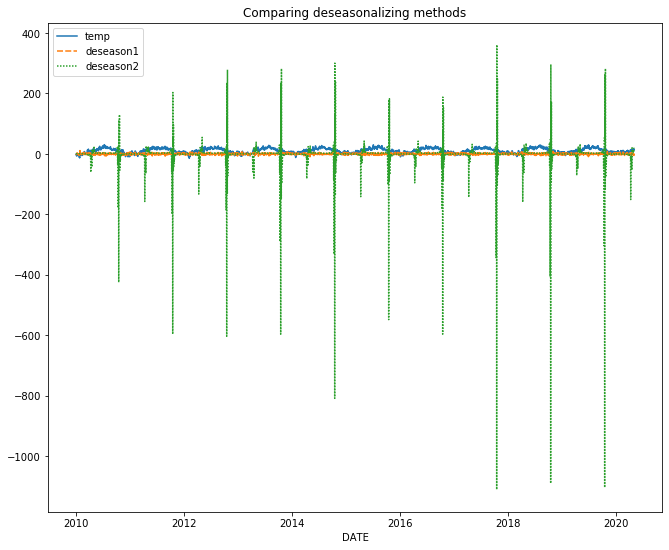

In [26]:
sns.lineplot(data=tempelhof.drop(['SOUID', 'month_name', 'month', 'year', 'diff1', 'diff2', 'diff3', 'monthly_mean'], axis=1)).set_title('Comparing deseasonalizing methods')

Text(0.5, 1.0, 'Effect of Stationarizing Methods')

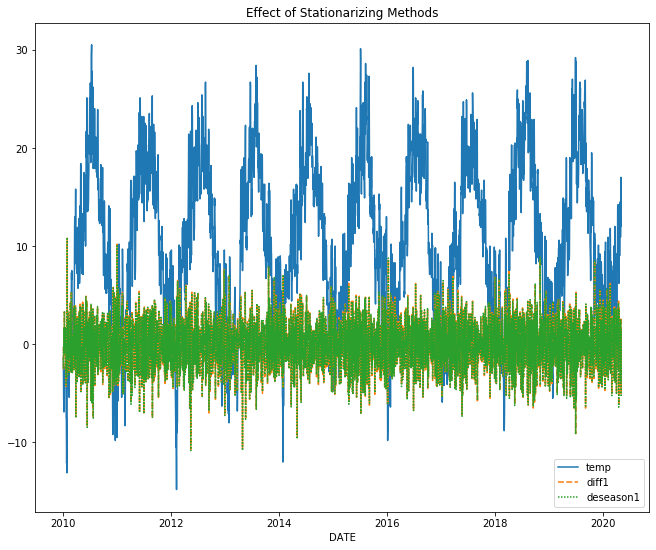

In [27]:
sns.lineplot(data=tempelhof.drop(['SOUID', 'month_name', 'month', 'year', 'diff2', 'diff3', 'monthly_mean', 'deseason2'], axis=1)).set_title('Effect of Stationarizing Methods')


### Reconstruct Data 

In [28]:
# reseason data
tempelhof['reseason']=tempelhof.deseason1 + tempelhof.monthly_mean

In [29]:
tempelhof.loc[tempelhof.index[0],'reseason']=tempelhof.loc[tempelhof.index[0], 'temp']
tempelhof['retrend']=np.cumsum(tempelhof['reseason'])

In [30]:
tempelhof.head()

,SOUID,temp,month_name,month,year,diff1,diff2,diff3,monthly_mean,deseason1,deseason2,reseason,retrend
DATE,,,,,,,,,,,,,
2010-01-01,111448,-1.4,January,1,2010,-0.3,-11.091719,-10.340204,-0.081471,-0.218529,0.181551,-1.4,-1.4
2010-01-02,111448,-1.7,January,1,2010,-0.3,-11.392233,-10.642640,-0.081471,-0.218529,0.250274,-0.3,-1.7
2010-01-03,111448,-4.3,January,1,2010,-2.6,-13.992746,-13.245076,-0.081471,-2.518529,0.542440,-2.6,-4.3
2010-01-04,111448,-5.6,January,1,2010,-1.3,-15.293260,-14.547511,-0.081471,-1.218529,0.601682,-1.3,-5.6
2010-01-05,111448,-6.0,January,1,2010,-0.4,-15.693773,-14.949947,-0.081471,-0.318529,0.633518,-0.4,-6.0


Text(0.5, 1.0, 'Original vs Reconstructed data')

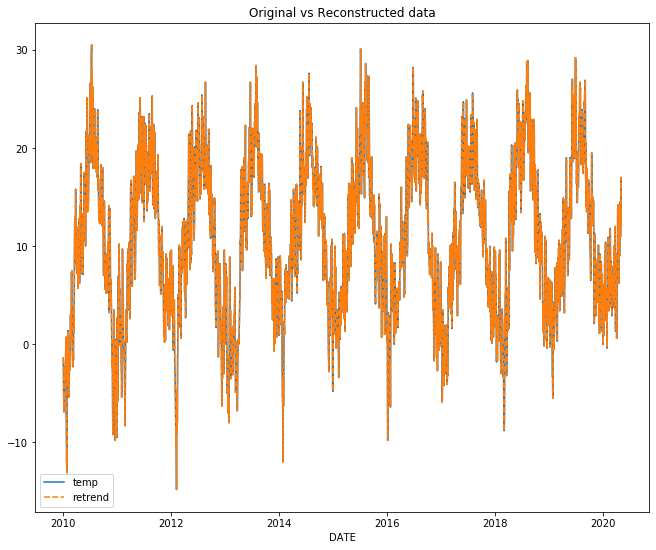

In [31]:
sns.lineplot(data=tempelhof.drop(['SOUID', 'month_name', 'month', 'year', 'diff1', 'diff2', 'diff3', 'monthly_mean', 'deseason1', 'deseason2', 'reseason'], axis=1)).set_title('Original vs Reconstructed data')